In [1]:
# these lines install modules cleantext and emoji. 
# Module cleantext is used to clean text data including: conversion of texts to lower case, removing unecessary panctuation and removal of stopwords.
# module emoji is needed to remove emocations from text.
!pip install cleantext 
!pip install emoji==1.7
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=0c00336e7f6203a62b0d85d5a0af0a94f33a4a6949d27e929d822e93b36a9b49
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.1.0
    Uninstalling emoji-2.1.0:
      Successfully uninstalled emoji-2.1.0
  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=205c74baa31a9374a7bad32e2a8a8a13b8915e84852e66dd97a6dd97d20b98a1
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# here are all the modules used during this analysis. 
# you can use help() to get documentation of each, eg help('pandas') will give you documentation of pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import cleantext 
import emoji 
import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras import datasets, layers, models,Input,Model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape,GlobalAveragePooling1D
import re
import keras
import shutil
import string
import random
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
import wget
import zipfile
import os
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from functools import reduce
from sklearn.tree import DecisionTreeClassifier as DR
from sklearn.ensemble import GradientBoostingClassifier as GBoost

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import pickle
from sklearn.decomposition import PCA
# call backs 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2022-12-03 11:54:00.900166: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 11:54:00.900207: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-03 11:54:00.962557: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-03 11:54:01.005343: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 11:54:01.005500: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [3]:

batch_size=64  #  Batch sizes to use
epoch =200      # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

# 4) Coronavirus tweets NLP - Text Classification

The data consists details of about 44,955 tweets labeled as extremely positive, positive, extremely negative, negative and neutral sentiment score. The data was collected during the month of March 2020. Twitter usernames has been replaced with new unique IDs to de-identify users (MIGLANI, 2020). The data is reasonably balanced between positive sentiments (19,592) and negative sentiment (17031). This makes it a good data to benchmark performance of binary text classifiers.

The data was loaded and combined into a single dataframe

In [4]:
Bench4_1 = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding_errors= 'replace') # load train 
Bench4_1['data']='train'                                                                                            # add column called data to help index the data once it is combined with other data  
Bench4_1=Bench4_1.iloc[:, 4:7].set_axis(["text","label","data"],axis=1)                                             # change column names
Bench4_2 = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding_errors= 'replace')  # load test 
Bench4_2=Bench4_2.iloc[:, 4:6].set_axis(["text","label"],axis=1)                                                    # change column names
random.seed(100)                                                                                                    #  random seed
test_ind=random.sample(range(len(Bench4_2)), k=round(len(Bench4_2) * 0.8))                                          # split testing data into twesting and validation here 80% will go to testing
valid_ind=list(set(range(len(Bench4_2))).difference(test_ind))                                                      # the remaining 20% to VALIDATION 
test=Bench4_2.iloc[test_ind,]                                                                                       # select test rows 
test['data']='test'                                                                                                 # add column called data to help index the data once it is combined with other data  
valid=Bench4_2.iloc[valid_ind,]                                                                                     # select validation 
valid['data']='valid'                                                                                               # add column called data to help index the data once it is combined with other data  
Bench4=pd.concat([Bench4_1, test,valid], axis = 0,ignore_index=True)                                                # join the datasets 
Bench4=Bench4[Bench4["label"]!="Neutral"]                                                                           # drop neutral label
#Bench4=Bench4.sample(n=2000)                                                                                        # sample data
Bench4['Index']=range(0,Bench4.shape[0])                                                                            # change labels
Bench4=Bench4.set_index('Index')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


Convert labels to binary `Positive`, `Negative`

In [5]:
def to_binary_labels(labels):
    if labels in ["Negative","Extremely Negative"]:
        x="Negative"
    else:
        x="Positive" 
    return x

Bench4['label']=pd.Series (list(map(to_binary_labels,Bench4['label'])))

Graphing article distribution across the two groups

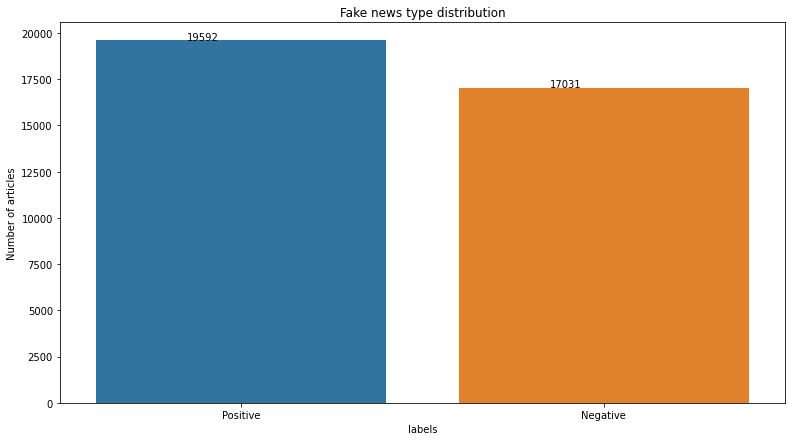

In [6]:
figure,ax=plt.subplots(nrows=1,ncols=1,figsize=(13,7))
sns.countplot(x='label',data=Bench4,ax=ax,order=Bench4.groupby('label').size().sort_values().index[::-1])
for p, label in zip(ax.patches, Bench4['label'].value_counts().index):
    ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    ax.set_xlabel("labels")
    ax.set_ylabel("Number of articles")
    ax.set_title('Fake news type distribution')
plt.savefig('tweetsdist.png')

Removing emojis and emocations

In [7]:
# remove emojis
def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

In [8]:
Bench4['text1']=Bench4['text'].apply(remove_emoji)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


Removing unicode characters

In [9]:
text1=[]
for j in range(Bench4.shape[0]):
    text1.append(Bench4["text1"][j].replace("’","'"))
Bench4["text1"]=pd.Series (text1)

In [10]:
# here we are getting the table to python in order to do the replacement.

strange=pd.read_html(requests.get('https://lhncbc.nlm.nih.gov/LSG/Projects/lvg/current/docs/designDoc/UDF/unicode/DefaultTables/symbolTable.html').content)[-1] #getting the webpage with the table

strange=strange.append(pd.DataFrame({'Unicode':["U+302D"],      #  cast the table into a dataframe
              'Mapped String':["..."],
              "Char":["…"],
              'Unicode Name':["THREE DOTS"]}),ignore_index=True) 
s_n=len(strange)
strange=strange.drop(list(strange["Mapped String"]).index("'"))

In [11]:
for j in range(Bench4.shape[0]):
    for i in [x for x in range(s_n) if x != 2]:
        Bench4["text1"][j]=Bench4["text1"][j].replace(strange["Char"][i],str(strange["Mapped String"][i]))

Next the labels were converted into two class dummy variables because neural networks won't allow character strings.This means because we have two classes, in this order postive,Negative. label [1 0] would mean postive while [0 1] would mean Negative. Here is a example using the first row.

In [12]:
def my_clean(text):
    try:
        x=cleantext.clean(text,clean_all= False, # Execute all cleaning operations
                           extra_spaces=True ,  # Remove extra white spaces 
                           stemming=False , # Stem the words
                           stopwords=False ,# Remove stop words
                           lowercase=True ,# Convert to lowercase
                           numbers=False ,# Remove all digits 
                           punct=False ,# Remove all punctuations
                           reg= "", # Remove parts of text based on regex
                           reg_replace='', # String to replace the regex used in reg
                           stp_lang='english')  # Language for stop words
    except BaseException as e:
        x=""
    return x

def my_clean1(text): 
    try:
        x=cleantext.clean(text,clean_all= False, # Execute all cleaning operations
                           extra_spaces=True ,  # Remove extra white spaces 
                           stemming=True , # Stem the words
                           stopwords=True ,# Remove stop words
                           lowercase=True ,# Convert to lowercase
                           numbers=True ,# Remove all digits 
                           punct=True ,# Remove all punctuations
                           reg= '\n', # Remove parts of text based on regex
                           reg_replace='', # String to replace the regex used in reg
                           stp_lang='english')  # Language for stop words
    except BaseException as e:
        x=""
    return x

In [13]:
Bench4['article']=Bench4['text1'].apply(my_clean) # apply cleaning
texts=Bench4['article'].apply(my_clean1)

In [14]:
leb=pd.get_dummies(Bench4['label']).values
print(leb[0],Bench4['label'][0])
print(leb[1],Bench4['label'][1])

[0 1] Positive
[0 1] Positive


The data downloaded had already been split into train, test,Valid so we here we subset each from the data we have subset.

In [15]:
train=Bench4[Bench4["data"]=="train"]
test=Bench4[Bench4["data"]=="test"]
valid=Bench4[Bench4["data"]=="valid"]

In [16]:
print("---------training breakdown-----------")
print()
print(train.label.value_counts())
print()
print("---------testing breakdown-----------")
print()
print(test.label.value_counts())
print()
print("---------validation breakdown-------")
print(valid.label.value_counts())

---------training breakdown-----------

Positive    18046
Negative    15398
Name: label, dtype: int64

---------testing breakdown-----------

Negative    1301
Positive    1228
Name: label, dtype: int64

---------validation breakdown-------
Negative    332
Positive    318
Name: label, dtype: int64


converting the data into tensorflow dataset to take advantage of these features.

In [17]:
train = tf.data.Dataset.from_tensor_slices((list(train["article"]),list(pd.get_dummies(train['label']).values)))
test = tf.data.Dataset.from_tensor_slices((list(test["article"]),list(pd.get_dummies(test['label']).values)))
valid = tf.data.Dataset.from_tensor_slices((list(valid["article"]),list(pd.get_dummies(valid['label']).values)))

2022-12-03 12:22:36.724545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 12:22:36.817008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 12:22:36.817766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 12:22:36.819877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
train= train.batch(batch_size=batch_size)
test= test.batch(batch_size=batch_size)
valid= valid.batch(batch_size=batch_size)

In [19]:
tf.data.experimental.save(train, "tweetstrain")
tf.data.experimental.save(test, "tweetstrain")
tf.data.experimental.save(valid, "tweetsvalid")

2022-12-03 12:22:40.475767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [20]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)

In [21]:
def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [22]:
vocabularies = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabularies, range(len(vocabularies))))

Text vectorizaton.It shows how the first article can be vectorized, into integers.

In [23]:
article,label= next(iter(train))
sample_article,sample_label = article[0],label[0]
print("Article:")
print(sample_article)
lb=["Reliable","Fake"]
print("Label:")
print(sample_label)
print("After vectorization:")
print(vectorize_articles(sample_article,sample_label))

Article:
tf.Tensor(b'advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order', shape=(), dtype=string)
Label:
tf.Tensor([0 1], shape=(2,), dtype=uint8)
After vectorization:
(<tf.Tensor: shape=(1, 38), dtype=int64, numpy=
array([[ 554,  955,    3,   34, 2621,  271,    3, 3109,  902, 1265,  996,
         444,  438,   20,  902, 1265,    5, 2621, 1251, 4281, 3671, 5281,
         524,   48,   57,   53, 2507,   50,    1, 3050,  189,    5, 1132,
        3241,   49,   35,  109,  249]])>, <tf.Tensor: shape=(2,), dtype=uint8, numpy=array([0, 1], dtype=uint8)>)


2022-12-03 12:22:42.054303: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Here we did more configuration practices for our data. these include, caching and prefetching

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-12-03 12:22:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-03 12:22:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-03 12:22:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [26]:
embeddings_index = {}
with open("/kaggle/working/glove.6B.100d.txt") as file:
    for line in file:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [27]:
embedding_dim=100
hits = 0
misses = 0

# Prepare embedding matrix
embed_mat = np.zeros((max_tokens + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embed_mat[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15660 words (4340 misses)


Here the model layers were specified. this is just like on the original model.See explanation of the different on the links at the begging.

In [28]:
model4=Sequential(name="my_model")
model4.add(Input(shape=(None,), dtype="int32",name="input_articles"))
model4.add(Embedding(max_tokens + 1,
                    embedding_dim,embeddings_initializer=keras.initializers.Constant(embed_mat),
                    trainable=False,
                    name="embeddinglayer"))
model4.add(Dropout(0.2,name="dropout"))
model4.add(layers.Conv1D(8,5, activation='relu'))
model4.add(Dropout(0.2,name="dropout1"))
model4.add(BatchNormalization(name="batchnormalization"))
model4.add(Bidirectional(LSTM(8),name="Bidirectional2"))
model4.add(Dropout(0.2,name="dropout2"))
model4.add(Dense(units=8,activation="relu"))
model4.add(Dropout(0.2,name="dropout3"))
model4.add(Dense(units=2, activation="softmax"))

Compile the model with the metrics Accuracy,sensitivity,specificity, and precision. also categorical cross entropy loss function.

In [29]:
model4.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

visualizing fitting historyfitting the model

In [30]:
mod=model4.fit(
 train,
  validation_data=test,
 epochs=epoch,
    callbacks=[es_callback,tensorboard_callback])

Epoch 1/200


2022-12-03 12:25:57.838336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/523 [..............................] - ETA: 1:29:16 - loss: 0.7239 - accuracy: 0.4219 - Sensitivity: 0.9583 - Specificity: 0.0750 - Precision: 0.3833 - f1_score: 0.4186

2022-12-03 12:26:04.460750: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 12:26:04.460802: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/523 [..............................] - ETA: 7:02 - loss: 0.7105 - accuracy: 0.4531 - Sensitivity: 0.9074 - Specificity: 0.1081 - Precision: 0.4261 - f1_score: 0.4514   

2022-12-03 12:26:04.922371: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 12:26:04.923636: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 12:26:05.061362: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1053 callback api events and 1013 activity events. 
2022-12-03 12:26:05.080203: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 12:26:05.115949: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_03_12_26_05



 10/523 [..............................] - ETA: 1:08 - loss: 0.6979 - accuracy: 0.4812 - Sensitivity: 0.7508 - Specificity: 0.2202 - Precision: 0.4796 - f1_score: 0.4809

2022-12-03 12:26:05.134433: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_12_03_12_26_05/2a2423fb3122.trace.json.gz
2022-12-03 12:26:05.170029: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_03_12_26_05

2022-12-03 12:26:05.173791: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2022_12_03_12_26_05/2a2423fb3122.memory_profile.json.gz
2022-12-03 12:26:05.174968: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2022_12_03_12_26_05
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2022_12_03_12_26_05/2a2423fb3122.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2022_12_03_12_26_05/2a2423fb3122.overview_page.pb
Dumped tool data for i

523/523 [==============================] - 18s 15ms/step - loss: 0.6309 - accuracy: 0.6357 - Sensitivity: 0.5756 - Specificity: 0.6870 - Precision: 0.6108 - f1_score: 0.6357 - val_loss: 0.5769 - val_accuracy: 0.6951 - val_Sensitivity: 0.6979 - val_Specificity: 0.6922 - val_Precision: 0.7061 - val_f1_score: 0.6951
Epoch 2/200
523/523 [==============================] - 6s 11ms/step - loss: 0.5646 - accuracy: 0.7182 - Sensitivity: 0.6811 - Specificity: 0.7498 - Precision: 0.6990 - f1_score: 0.7182 - val_loss: 0.5368 - val_accuracy: 0.7343 - val_Sensitivity: 0.7548 - val_Specificity: 0.7125 - val_Precision: 0.7356 - val_f1_score: 0.7343
Epoch 3/200
523/523 [==============================] - 6s 11ms/step - loss: 0.5408 - accuracy: 0.7346 - Sensitivity: 0.7015 - Specificity: 0.7628 - Precision: 0.7162 - f1_score: 0.7346 - val_loss: 0.5404 - val_accuracy: 0.7232 - val_Sensitivity: 0.6072 - val_Specificity: 0.8461 - val_Precision: 0.8069 - val_f1_score: 0.7232
Epoch 4/200
523/523 [============

In [31]:
model4.save("model4") 
with open("mod3_hist.pkl","wb") as file:
    pickle.dump(mod.history,file)

2022-12-03 12:41:47.721944: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


visualizing fitting history

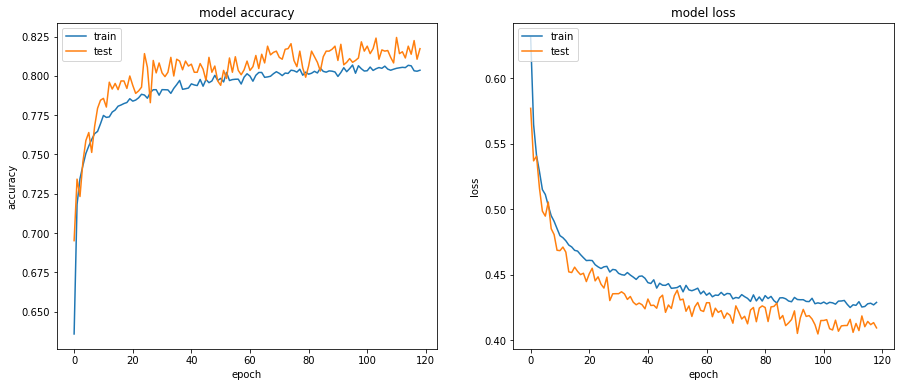

In [32]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(mod.history['loss'])
ax[1].plot(mod.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('othercomparing7.png')

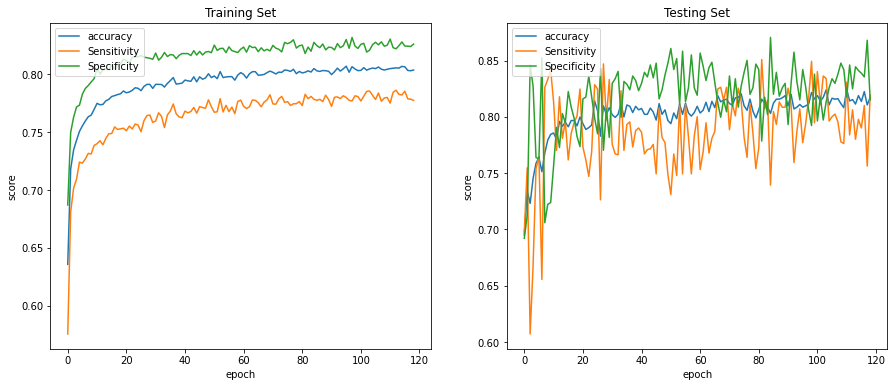

In [33]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(mod.history['val_accuracy'])
ax[1].plot(mod.history['val_Sensitivity'])
ax[1].plot(mod.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['Sensitivity'])
ax[0].plot(mod.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('othercomparing8.png')

Evaluating the model

In [34]:
mod4=model4.evaluate(test)[1:6]
mod4=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod4]})
mod4

40/40 [==============================] - 0s 6ms/step - loss: 0.4094 - accuracy: 0.8173 - Sensitivity: 0.8194 - Specificity: 0.8151 - Precision: 0.8244 - f1_score: 0.8173


,Measure,Original Dataset
0,Accuracy,0.8173
1,Sensitivity,0.8194
2,Specificty,0.8151
3,Precision,0.8244
4,F1 score,0.8173


Extracting features to use in kmeans

In [35]:
feature_miner=Model(
    inputs=model4.inputs,
    outputs=model4.get_layer(name="Bidirectional2").output,name="feature_miner"
)

fitting kmeans model

In [36]:
predictors=feature_miner.predict(train)
kmea=KMeans(n_clusters=2, random_state=0).fit(predictors)
tests=feature_miner.predict(test)
kmeans_pred=kmea.predict(tests)
kmea.labels_

array([0, 0, 0, ..., 1, 0, 1], dtype=int32)

In [37]:
with open("predictors4.pkl","wb") as file:
    pickle.dump(predictors,file)
    
with open("tests4.pkl","wb") as file:
    pickle.dump(tests,file)
    
with open("kmea4.pkl","wb") as file:
    pickle.dump(kmea,file)

In [38]:
def labels(ds):
    labels=[]
    for batch in ds:
        articles,labelss=batch
        labelss=labelss.numpy()
        labels.append(labelss)
    labels=np.concatenate(labels)
    return labels

label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [39]:
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.19770660340055357
0.8022933965994464


In [40]:
kmeans_pred1=kmeans_pred
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

Evaluating the model.

In [41]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             'Bench4':[metrics.accuracy_score(label_test,kmeans_pred),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=0),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=1),
                        metrics.precision_score(label_test,kmeans_pred,pos_label=0),
                        metrics.f1_score(label_test,kmeans_pred,pos_label=0)]})

,Measure,Bench4
0,Accuracy,0.802293
1,Sensitivity,0.887010
2,Specitivity,0.712541
3,Precision,0.765760
4,F1 score,0.821937


Next was to weight between the predictions of clustering and those from model prediction. Here a user defined function was used, which compares sensitivity from the clustering predictions and those that of from the ANN. the the model with higher sensitivity will be used to predict the the fake news class. conversely the model with higher specificity predicts the other category.

**Evaluation on the testing set**

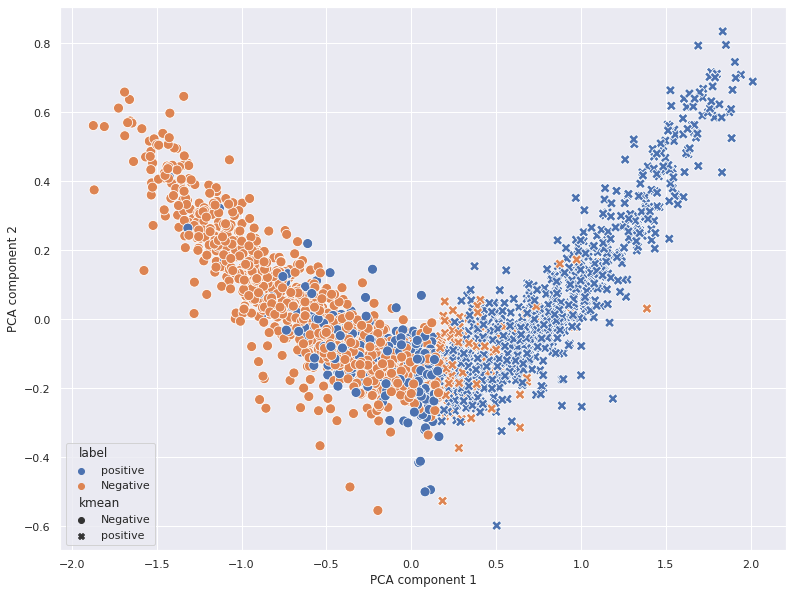

In [42]:
pca = PCA(2)
pcas= pd.DataFrame(pca.fit_transform(tests), columns = ['x','y'])
pcas['kmean']= kmeans_pred
pcas['label']= label_test

def to_binary_labels(labels):
    if labels ==0:
        x="Negative"
    else:
        x= "positive" 
    return x

pcas['label']=pd.Series (list(map(to_binary_labels,pcas['label'])))
pcas['kmean']=pd.Series (list(map(to_binary_labels,pcas['kmean'])))
sns.set(rc={"figure.figsize":(13, 10)}) 
sns.scatterplot(data=pcas, x="x", y="y",s=100,style="kmean",hue='label')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.savefig('PCA4.png')

In [43]:
modelpred=np.argmax(model4.predict(test), axis=1)
sensdeep=metrics.recall_score(label_test, modelpred,pos_label=0)
senskmeans=metrics.recall_score(label_test,kmeans_pred,pos_label=0)
specdeep=metrics.recall_score(label_test, modelpred,pos_label=1)
speckmean=metrics.recall_score(label_test,kmeans_pred,pos_label=1)
def weighting(kmeans_pred,modelpred):
    conditionals= [] 
    unconditionals=[]
    types= [] 
    for i in range(len(kmeans_pred)):
        if modelpred[i]==0 and kmeans_pred[i]==0:
            x=[sensdeep*senskmeans,(1-specdeep)*(1-speckmean)]
        elif modelpred[i]==1 and kmeans_pred[i]==1:
            x=[(1-sensdeep)*(1-senskmeans),specdeep*speckmean]
        elif modelpred[i]==0 and kmeans_pred[i]==1:
            x=[sensdeep*(1-senskmeans),(1-specdeep)*speckmean]
        else:
            x=[(1-sensdeep)*senskmeans,specdeep*(1-speckmean)]
        conditionals.append(x)
        unconditionals.append((np.array(x)/sum(x)).tolist())
    preds=np.argmax(unconditionals,axis=1)
    return preds
preds=weighting(modelpred,kmeans_pred)

In [44]:

pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             "Weighted":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Weighted
0,Accuracy,0.817319
1,Sensitivity,0.819370
2,Specitivity,0.815147
3,Precision,0.824439
4,F1 score,0.821897


**Validation**

In [45]:
modelpred=np.argmax(model4.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

preds=weighting(modelpred,kmeans_pred)

In [46]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1 score'],
             "weighted":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})

,Measure,weighted
0,Accuracy,0.804615
1,Sensitivity,0.798193
2,Specitivity,0.811321
3,Precision,0.815385
4,F1 score,0.806697
